In [1]:
import mne, os
import signal_processing.pre_process as prep
import basic.arrange_data as arrange
import numpy as np
from cmath import nan
import matplotlib.pyplot as plt
import pandas as pd
from autoreject import (get_rejection_threshold, AutoReject)

mne.set_log_level('error')

**Set the folder of EEG files**

Run the cell to be prompted with an input box for choosing the folder containing the EEG files of interest.

*NB! The path has to be in 'Data\Raw\' folder relative to this notebook.*

In [2]:
exp_folder = r"Auditory Oddball/Baseline" # in case you want to just type the dir here
#exp_folder = input('Experiment folder (e.g., Eyes Open\Baseline):')

raw_folder = r"Data/Raw/OKTOS/"
clean_folder = r"Data/Clean/OKTOS"
dir_inprogress = os.path.join(raw_folder,exp_folder)
export_dir = os.path.join(clean_folder,exp_folder)

results_foldername = r"Results/OKTOS"
exp_condition = r"AO_T00"

file_dirs, subject_names = arrange.read_files(dir_inprogress,".bdf")

Files in Data/Raw/OKTOS/Auditory Oddball/Baseline read in: 27


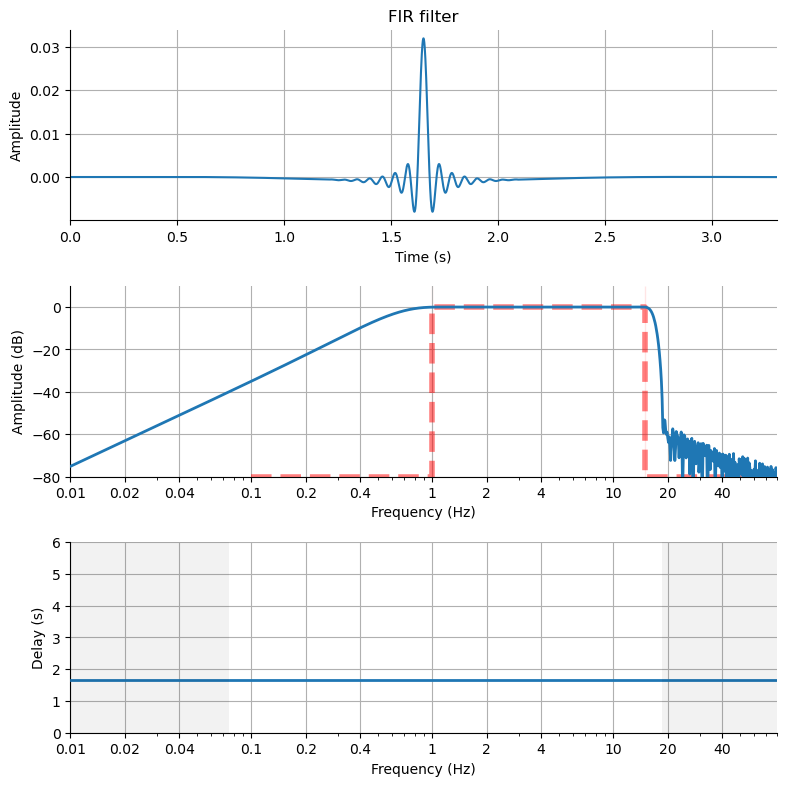

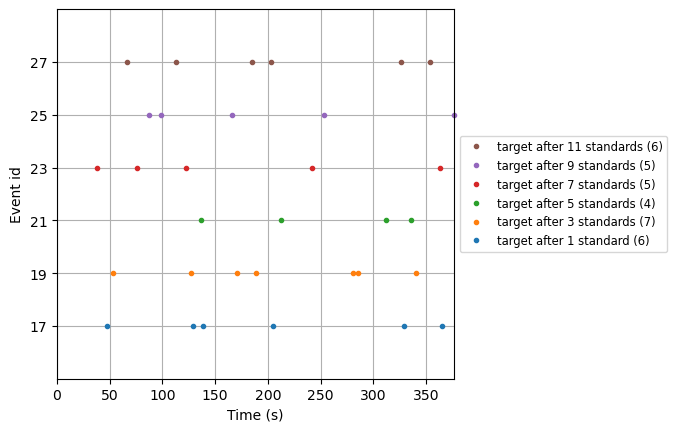

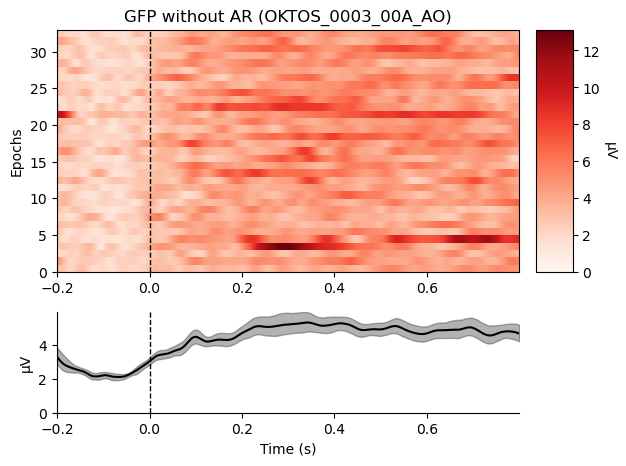

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 8.166815999245963e-05}
Running autoreject on ch_type=eeg




Estimated consensus=1.00 and n_interpolate=31
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


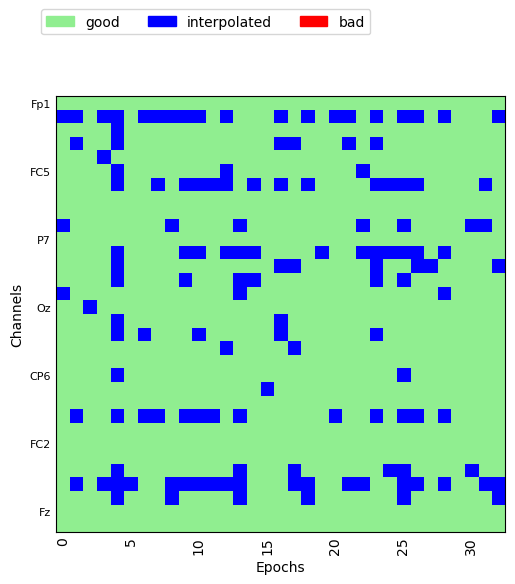

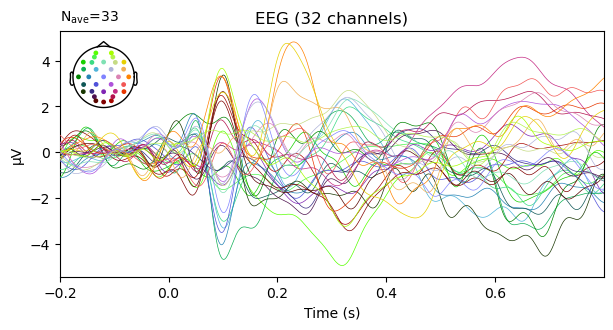

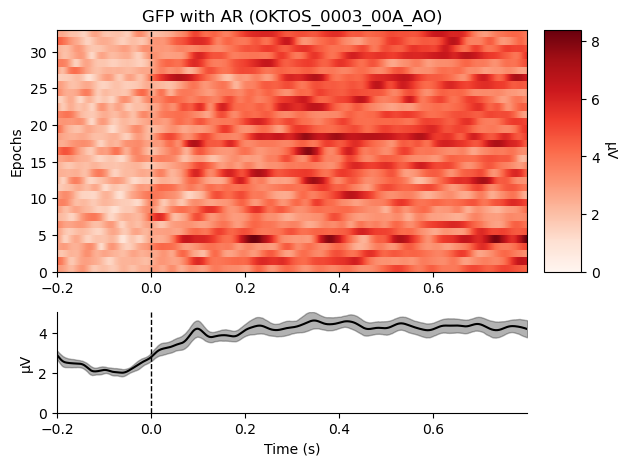

Number of events,33
Events,target after 1 standard: 6target after 11 standards: 6target after 3 standards: 7target after 5 standards: 4target after 7 standards: 5target after 9 standards: 5
Time range,-0.200 – 0.800 sec
Baseline,-0.200 – 0.000 sec


In [4]:
tminmax = [-0.2, 0.8]
baseline_correction = (None,0)
event_dict = {'target after 1 standard': 17, 'target after 3 standards': 19,
                'target after 5 standards': 21, 'target after 7 standards': 23,
                'target after 9 standards': 25, 'target after 11 standards': 27}
target_ids = [17, 19, 21, 23, 25, 27]
button_id = 32
verbose = False
eog_channels = ["EXG1","EXG2","EXG3","EXG4","EXG5","EXG6","EXG7","EXG8"]
stimulus_channel = "Status"

# Parameters for filter
filter_design = dict(l_freq=1,h_freq=15,filter_length='auto',method='fir',
                     l_trans_bandwidth='auto',h_trans_bandwidth='auto',
                     phase='zero',fir_window='hamming',fir_design='firwin')

for i in range(len(file_dirs)):
        # Read in the raw EEG data
        raw = mne.io.read_raw_bdf(file_dirs[i], infer_types=True, eog=eog_channels,
                                  stim_channel=stimulus_channel)

        # Set the right montage (Biosemi32) and set reference as average across all channels
        raw = raw.set_montage(mne.channels.make_standard_montage("biosemi32")).load_data()\
                 .set_eeg_reference(ref_channels='average',verbose=verbose)
    
        # Filter the signal with bandpass filter and remove EOG artefacts with SSP
        filt = prep.filter_raw_data(raw,filter_design,line_remove=None,eog_channels=eog_channels,plot_filt=True,savefig=False)
        
        # Find events from the filtered EEG data and name them
        events = mne.find_events(filt,stim_channel=stimulus_channel,consecutive=False,output='onset')
        buttontarget_events = []

        # Create an array of target tone events which have been responded with a button press (acknowledged deviant tones only)
        for m in range(len(events)):
                for n in target_ids:
                        if events[m][2] == n and events[m+1][2] == button_id:
                                buttontarget_events.append(events[m])
        buttontarget_events = np.asarray(buttontarget_events)
        
        # Plot all the events
        %matplotlib inline
        fig = mne.viz.plot_events(buttontarget_events, sfreq=filt.info['sfreq'],
                                first_samp=filt.first_samp,event_id=event_dict)
        fig.subplots_adjust(right=0.7)  # make room for legend

        # Create epochs time-locked to target tone events which are followed by button press
        picks = mne.pick_types(filt.info,eeg=True,stim=False)
        epochs = mne.Epochs(filt,buttontarget_events,event_id=event_dict,tmin=tminmax[0],tmax=tminmax[1],
                            baseline=baseline_correction,picks=picks,preload=True)
        
        # Plot the epochs' GFP plot before artefact rejection
        epochs.plot_image(title="GFP without AR ({})".format(subject_names[i]))

        # Use AutoReject to repair and remove epochs which are artefactual
        reject_criteria = get_rejection_threshold(epochs)
        print('Dropping epochs with rejection threshold:',reject_criteria)
        epochs.drop_bad(reject=reject_criteria)

        ar = AutoReject(thresh_method='random_search',random_state=1)
        ar.fit(epochs)
        epochs_ar, reject_log = ar.transform(epochs, return_log=True)

        reject_log.plot('horizontal')

        # Plot the epochs' GFP after artefact rejection
        epochs_ar.average().plot()
        epochs_ar.plot_image(title="GFP with AR ({})".format(subject_names[i]))

        # Display the final epochs object meta-data
        display(epochs_ar)

        # Save the cleaned EEG file as .fif file
        try:
                os.makedirs(export_dir)
        except FileExistsError:
                pass
        try:
                mne.Epochs.save(epochs_ar,fname='{}/{}_clean-epo.fif'.format(export_dir,subject_names[i]),overwrite=True)
        except FileExistsError:
                pass